# Determining factors driving rates of arrest
This notebook models quantity of arrests and rates of arrest by precinct using crime, income, and population data.  A preference is made towards using interpretable models because we would like to see what factors affect the quantity of arrests made besides the amount of crime.

Because public arrest and complaint data both incude precinct of occurence, modeling data is aligned on an axis containing each precinct.


In [74]:
import numpy as np
import pandas as pd

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)

In [75]:
complaints = pd.read_csv('data/complaints_2018_final.csv')
arrests = pd.read_csv('data/nypd-arrest-data-year-to-date-1.csv')

# Census data - census.gov
populations = pd.read_csv('./data/nyc_2010pop_2020precincts.csv')

# Census data - census.gov
income = pd.read_csv('./data/income census data/median_inc.csv')

# census to precinct key created by John Keefe
# available from https://johnkeefe.net/nyc-police-precinct-and-census-data
key = pd.read_csv('./data/precinct_block_key_2020.csv')

---

### Cleaning / EDA

#### Complaints

In [76]:
# Creating complaints per precinct list
pct_complaints = complaints.groupby(['addr_pct_cd']).count()['cmplnt_num']

In [77]:
pct_complaints.head()

addr_pct_cd
-99.0      747
 1.0     13326
 5.0      8885
 6.0     10105
 7.0      8246
Name: cmplnt_num, dtype: int64

In [78]:
pct_complaints.drop(index=[-99], inplace=True)
pct_complaints.drop(index=[22], inplace=True) # Central Park Precinct isn't good for modeling

In [79]:
pct_complaints.index = [int(pct) for pct in pct_complaints.index]

In [80]:
pct_complaints.index

Int64Index([  1,   5,   6,   7,   9,  10,  13,  14,  17,  18,  19,  20,  23,
             24,  25,  26,  28,  30,  32,  33,  34,  40,  41,  42,  43,  44,
             45,  46,  47,  48,  49,  50,  52,  60,  61,  62,  63,  66,  67,
             68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  81,  83,
             84,  88,  90,  94, 100, 101, 102, 103, 104, 105, 106, 107, 108,
            109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123],
           dtype='int64')

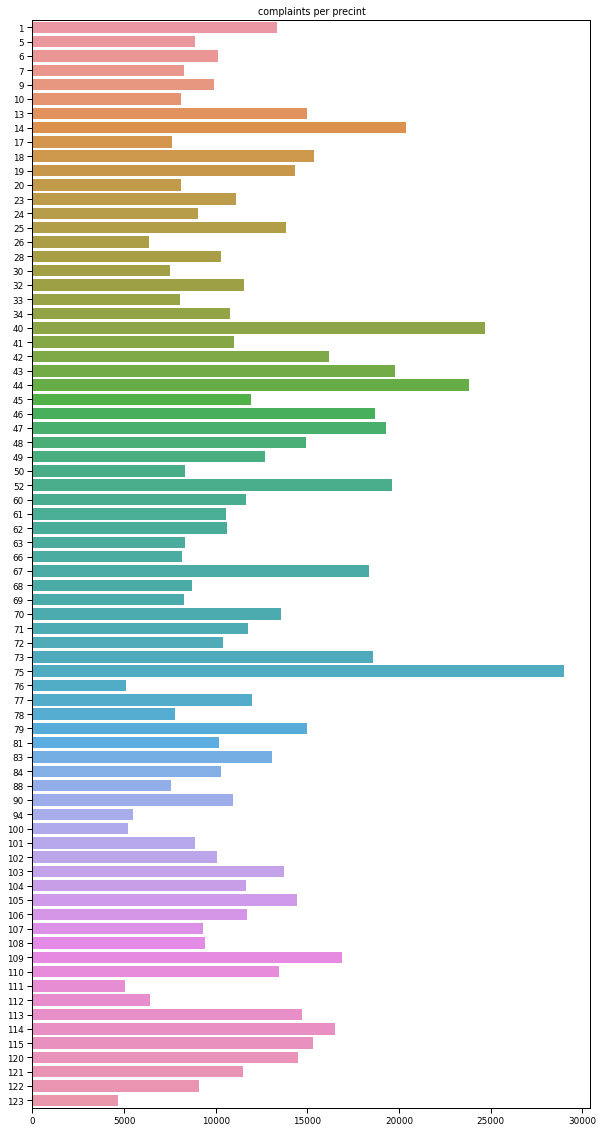

In [81]:
plt.figure(figsize=(10,20))
sns.barplot(pct_complaints.values, pct_complaints.index, orient='h')\
            .set(title='complaints per precint');

#### Arrests

In [82]:
# snakecase the arrest dataframe
arrests = arrests.applymap(lambda x: x.strip().lower().replace(' ', '_') if type(x)==str else x)

new_ar_col_list = [col.strip().lower().replace(' ', '_') for col in arrests.columns]
arrests.columns = new_ar_col_list

In [83]:
# Creating arrests per precinct list
pct_arrests = arrests.groupby(['arrest_precinct']).count()['arrest_key']

In [84]:
# remove central park
pct_arrests.drop(index=22, inplace=True)

In [85]:
pct_arrests.index

Int64Index([  1,   5,   6,   7,   9,  10,  13,  14,  17,  18,  19,  20,  23,
             24,  25,  26,  28,  30,  32,  33,  34,  40,  41,  42,  43,  44,
             45,  46,  47,  48,  49,  50,  52,  60,  61,  62,  63,  66,  67,
             68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  81,  83,
             84,  88,  90,  94, 100, 101, 102, 103, 104, 105, 106, 107, 108,
            109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123],
           dtype='int64', name='arrest_precinct')

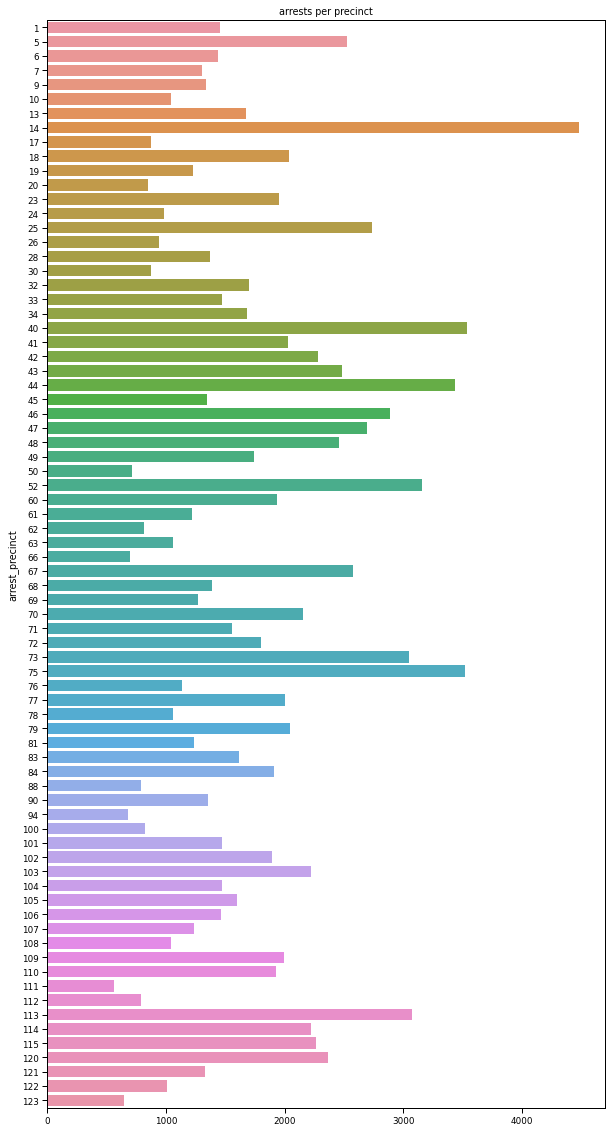

In [86]:
plt.figure(figsize=(10,20))
sns.barplot(pct_arrests.values, pct_arrests.index, orient='h')\
        .set(title='arrests per precinct');

#### Cross
The ```cross``` dataframe will be the main dataframe from which X and y will come from.  It will contain the number of arrests, the number of complaints, and possibly the break-down of arrests or complaints by type.  Also should contain population and income data.

In [87]:
# Create dataframe containing both arrest & complaint data for each precinct

cross = pd.concat([pct_arrests, pct_complaints], axis=1)
cross.reset_index(inplace=True)
cross.rename(columns={'arrest_key':'arrests', 'cmplnt_num':'complaints', 'index':'precinct'}, inplace=True)

In [88]:
cross.head(5)

,precinct,arrests,complaints
0,1,1454,13326
1,5,2523,8885
2,6,1439,10105
3,7,1303,8246
4,9,1339,9893


In [89]:
# Get rid of central park precint
populations.drop(index=12, inplace=True)

In [90]:
populations.head(15)

,precinct_2020,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,...,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073
0,1,66679,64416,50484,2162,89,10569,26,1086,2263,...,0,1,1,0,0,0,0,0,0,0
1,5,52568,51415,13436,2784,81,32795,18,2301,1153,...,0,1,1,0,0,0,0,0,0,0
2,6,62226,60490,53227,1316,80,5023,21,823,1736,...,0,2,2,0,0,0,0,0,0,0
3,7,56355,54055,21520,5992,326,19328,28,6861,2300,...,0,2,0,2,0,0,0,0,0,0
4,9,76443,73259,48175,6904,361,10946,45,6828,3184,...,0,2,1,1,0,0,0,0,0,0
5,10,50180,48333,35838,4171,170,5653,15,2486,1847,...,0,2,1,1,0,0,0,0,0,0
6,13,93640,90828,70786,4864,194,12883,39,2062,2812,...,0,0,0,0,0,0,0,0,1,1
7,14,20651,20019,12868,1481,56,4964,13,637,632,...,0,0,0,0,0,0,0,0,0,0
8,17,79126,77567,63691,1711,71,11097,45,952,1559,...,0,0,0,0,0,0,0,0,0,0
9,18,54066,52216,37624,3106,168,8462,27,2829,1850,...,0,0,0,0,0,0,0,0,0,0


In [91]:
cross.shape, populations.shape

((76, 3), (76, 145))

In [92]:
cross = pd.merge(left=cross, right=populations,
                 left_on='precinct', right_on='precinct_2020') # Add census population data to dataframe

In [93]:
pct_list = set(cross['precinct'])

In [94]:
cross['arrests'].head()

0    1454
1    2523
2    1439
3    1303
4    1339
Name: arrests, dtype: int64

---

#### Arrests per complaint

In [95]:
cross['apc'] = cross['arrests'] / cross['complaints']
print('min arrest per complaints:', cross['apc'].min())
print('max arrest per complaints:', cross['apc'].max())

min arrest per complaints: 0.07701008577622773
max arrest per complaints: 0.2839617332583005


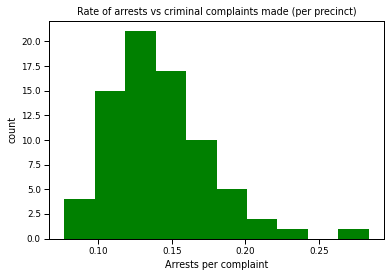

In [96]:
plt.hist(cross['apc'], color='green')
plt.title('Rate of arrests vs criminal complaints made (per precinct)');
plt.xlabel('Arrests per complaint')
plt.ylabel('count')
plt.savefig('apc.jpg')

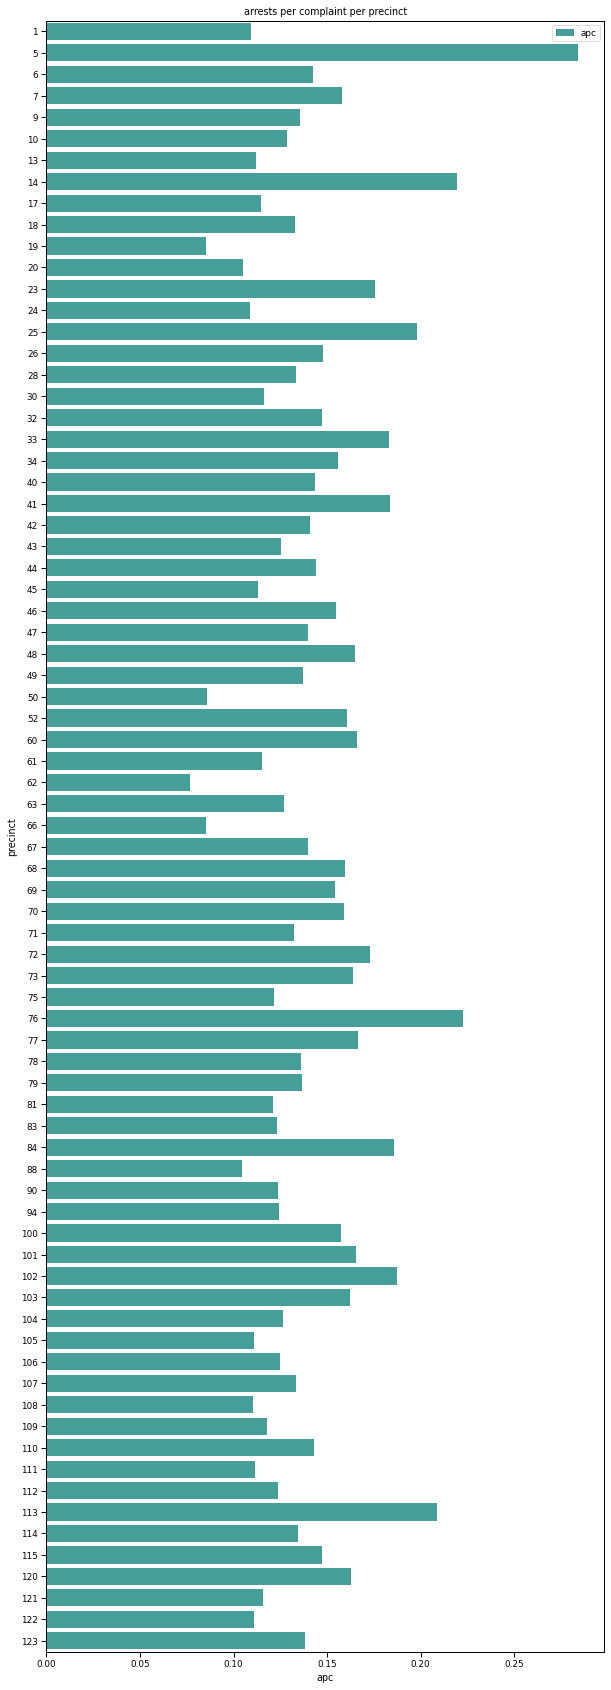

In [97]:
plt.figure(figsize=(10,30))
sns.barplot(cross['apc'], cross['precinct'], orient='h',
            label='apc',color=sns.husl_palette(2)[1])\
            .set(title='arrests per complaint per precinct');
plt.legend();

#### Complaints & Arrests per precinct

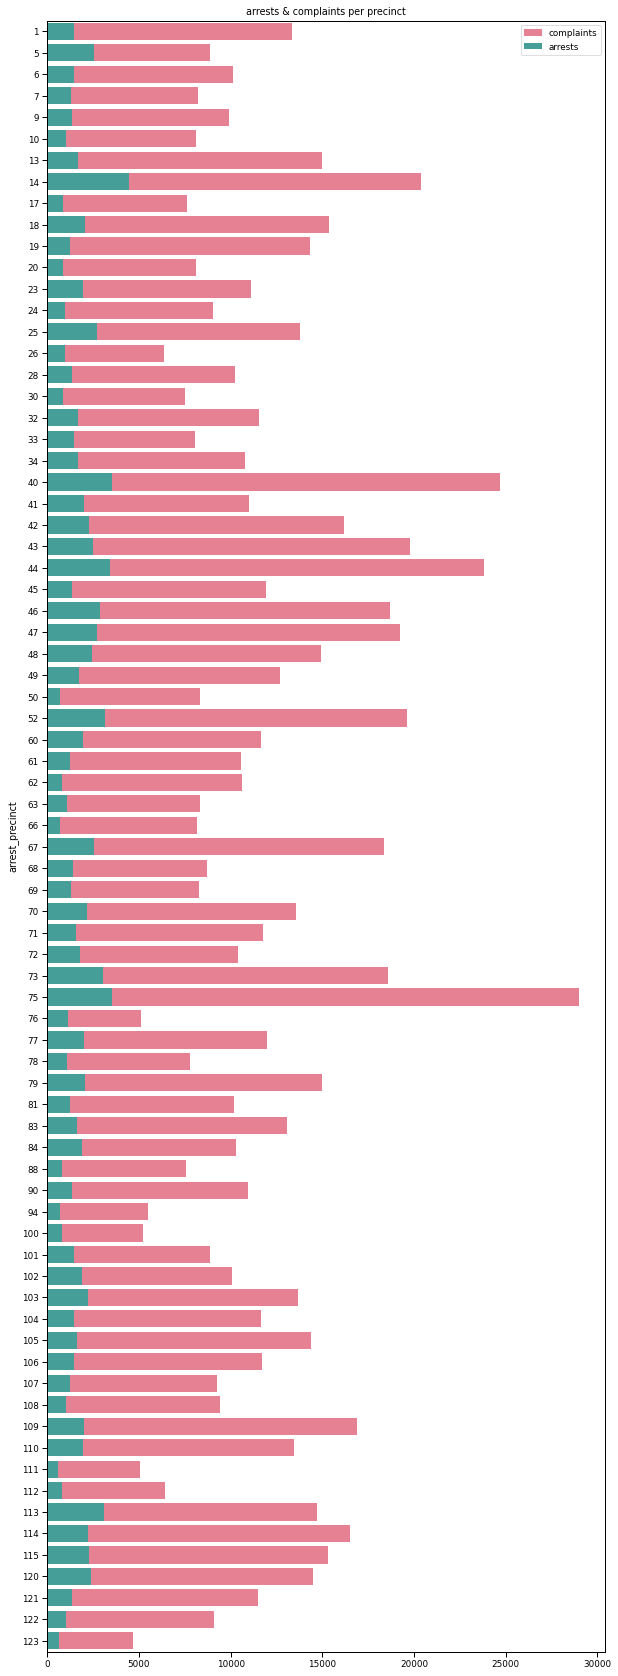

In [98]:
plt.figure(figsize=(10,30))
sns.barplot(pct_complaints.values, pct_complaints.index, orient='h',
            label='complaints',color=sns.husl_palette(2)[0]);
sns.barplot(pct_arrests.values, pct_arrests.index, orient='h',
            label='arrests', color=sns.husl_palette(2)[1])\
            .set(title='arrests & complaints per precinct');
plt.legend();

---

### Arrests by type per precinct

In [99]:
# Breaks out counts of each type of arrest per precinct
# Expect to take a minute or two to run
arrest_counts = pd.DataFrame()
for each_pct in pct_list:
    # Summarize each crime type per precinct
    arrest_types = arrests[arrests['arrest_precinct']==each_pct]['pd_desc'].value_counts()
    arrest_types = pd.DataFrame(arrest_types.rename(each_pct)).T
    
    # Divide by precinct population to standardize as crime / person
    arrest_types /= populations[populations['precinct_2020']==each_pct]['P0010001'].values[0]
    
    # Append to the list
    arrest_counts = arrest_counts.append(arrest_types)

In [100]:
# change column headers to make it clear they refer to arrests
arr_type_cols = [(col+'_arrests') for col in arrest_counts.columns]
arrest_counts.columns = arr_type_cols

#### Crime Analysis
We can examine the rates that specific offenses are enforced.  Marijuana analysis of 2018 vs 2020 would be interesting to examine, for instance, because of changes made in 2019 to the enforcement of marijuana in New York City.

In [109]:
for charge in arrest_counts.T.index:
    if 'marij' in charge:
        print(charge)
        print(arrest_counts[charge].mean())
        print()
        

marijuana,_possession_4_&_5_arrests
0.0009718651771365778

marijuana,_sale_4_&_5_arrests
0.00019099168054263516

unlawful_sale_synthetic_marijuana_arrests
0.00014129488579261773

marijuana,_sale_1,_2_&_3_arrests
2.0412876278341657e-05

marijuana,_possession_1,_2_&_3_arrests
4.393318908394193e-05

marijuana,_possession_arrests
4.877957994482465e-05



In [113]:
arrest_counts['marijuana,_possession_4_&_5_arrests'].sort_values(ascending=False).head()

14    0.004988
40    0.004077
25    0.003881
23    0.002654
73    0.001989
Name: marijuana,_possession_4_&_5_arrests, dtype: float64

In [109]:
# We can add arrest types here
# cross = pd.merge(cross, crime_counts, left_on=('precinct'), right_index=True)

In [110]:
cross.head()

,precinct,arrests,complaints,precinct_2020,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,...,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073,apc
0,1,1454,13326,1,66679,64416,50484,2162,89,10569,...,1,1,0,0,0,0,0,0,0,0.109110
1,5,2523,8885,5,52568,51415,13436,2784,81,32795,...,1,1,0,0,0,0,0,0,0,0.283962
2,6,1439,10105,6,62226,60490,53227,1316,80,5023,...,2,2,0,0,0,0,0,0,0,0.142405
3,7,1303,8246,7,56355,54055,21520,5992,326,19328,...,2,0,2,0,0,0,0,0,0,0.158016
4,9,1339,9893,9,76443,73259,48175,6904,361,10946,...,2,1,1,0,0,0,0,0,0,0.135348


### Complaints by type per precinct

In [111]:
# Breaks out counts of each type of complaint per precinct
# Expect to take a minute or two to run
complaint_counts = pd.DataFrame()
for each_pct in pct_list:
    # Summarize each crime type per precinct
    complaint_types = complaints[complaints['addr_pct_cd']==each_pct]['pd_desc'].value_counts()
    complaint_types = pd.DataFrame(complaint_types.rename(each_pct)).T
    
    # Divide by precinct population to standardize as crime / person
    complaint_types /= populations[populations['precinct_2020']==each_pct]['P0010001'].values[0]
    
    # Add to the list
    complaint_counts = complaint_counts.append(complaint_types)

In [112]:
# change column headers to make it clear they refer to complaints
comp_type_cols = [(col+'_complaints') for col in complaint_counts.columns]
complaint_counts.columns = comp_type_cols

In [113]:
cross = pd.merge(cross, complaint_counts, left_on=('precinct'), right_index=True)

In [114]:
cross.shape

(76, 518)

In [115]:
cross.isnull().sum()

precinct                                        0
arrests                                         0
complaints                                      0
precinct_2020                                   0
P0010001                                        0
                                               ..
traffic_unclassified_infractio_complaints      75
disseminating_a_false_sex_offend_complaints    75
dis_con_aggravated_complaints                  73
poss_meth_manufact_material_complaints         75
fac__sexual_offense_w_controll_complaints      75
Length: 518, dtype: int64

In [116]:
cross.fillna(0, inplace=True)

---

### adding income by precinct

In [117]:
# this section uses census to precinct key created by John Keefe
# available from https://johnkeefe.net/nyc-police-precinct-and-census-data

# slice the parts of the census income data and the key to match
income['id'] = income['GEO_ID'].map(lambda x: x[9:])
key['id'] = key['geoid10'].map(lambda x: str(x)[:12])

income.drop(index=0, inplace=True)

In [118]:
income.head(3)

,GEO_ID,NAME,B19013_001E,B19013_001M,id
1,1500000US360810037001,"Block Group 1, Census Tract 37, Queens County,...",-,**,360810037001
2,1500000US360810043002,"Block Group 2, Census Tract 43, Queens County,...",-,**,360810043002
3,1500000US360810050001,"Block Group 1, Census Tract 50, Queens County,...",-,**,360810050001


In [119]:
income['B19013_001E']

1            -
2            -
3            -
4            -
5            -
         ...  
6489     72722
6490     75250
6491    101519
6492    156220
6493    128147
Name: B19013_001E, Length: 6493, dtype: object

In [120]:
#replacing - with 0 to be able to convert to int; make sure these are accounted for
# this math probably needs to be fixed.  
income.replace('-',np.nan, inplace=True)
income.replace('250,000+', 250000, inplace=True)

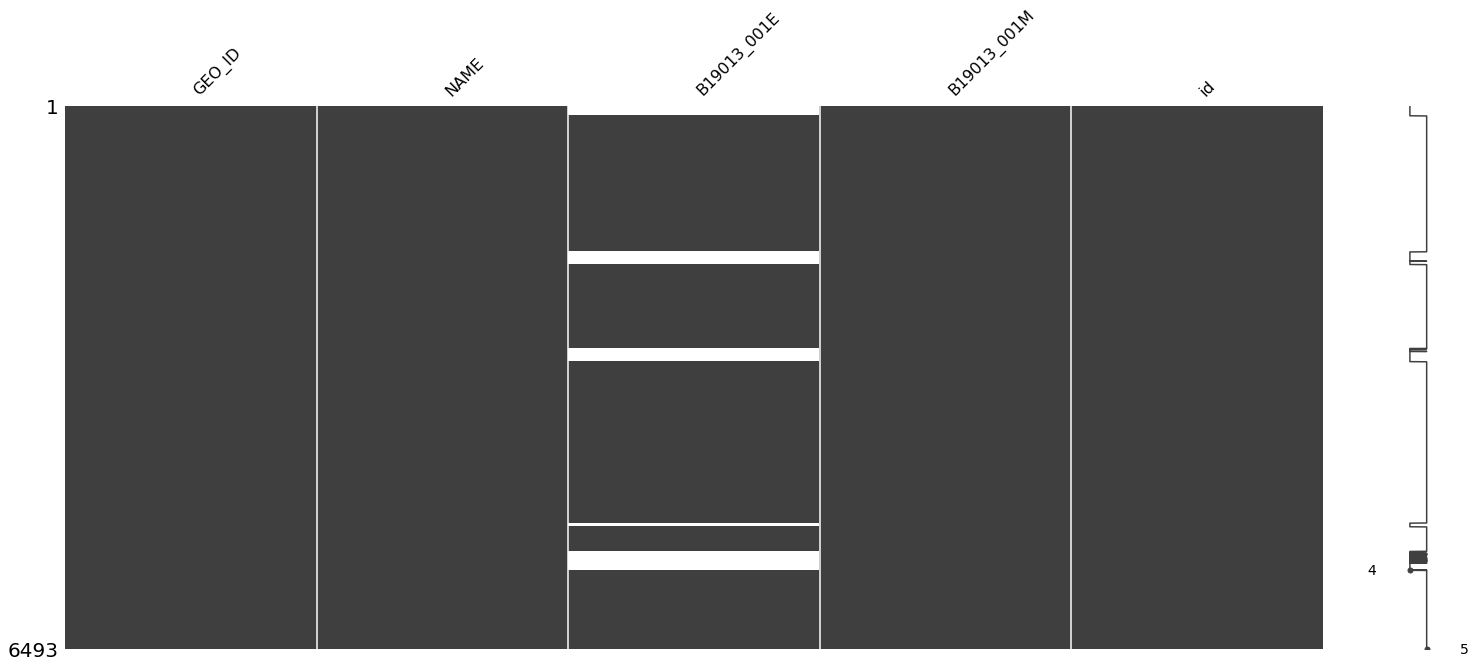

In [121]:
msno.matrix(income);

In [122]:
income.dropna(inplace=True)

In [123]:
income['median_inc'] = income['B19013_001E'].astype(int)

In [124]:
income.groupby(['id']).mean('median_inc')

,median_inc
id,
360050002001,43808
360050002002,58661
360050002003,65500
360050004002,59205
360050004003,85417
...,...
360850319011,6469
360850319012,75602
360850319021,9149


In [133]:
pct_income = pd.DataFrame(key['id'])
income = income.merge(key, on='id')
income.rename(columns={'precinct_2020':'precinct'}, inplace=True)
income.dropna(inplace=True)

In [134]:
income['precinct'] = income['precinct'].astype(int)

In [248]:
# This gives the mean of the median of annual household income.  Ideally the median of each geo_id
# should be multiplied by the population of the geo_id, and then the true average for the precinct
# could be derived from total area ami/pop.  This would give more accurate results.
income.groupby(['precinct']).mean('median_inc').head(3)

,median_inc,geoid10
precinct,,
1,189843.595568,3.606100e+14
5,73652.353846,3.606100e+14
6,144209.645320,3.606101e+14


In [137]:
# adding income to dataframe
cross = cross.merge(income.groupby(['precinct']).mean('median_inc'), how='left', on='precinct')

In [138]:
cross[cross['precinct']==50]['median_inc']

31    83437.322129
Name: median_inc, dtype: float64

In [139]:
cross.drop(columns=['geoid10'], inplace=True)

In [140]:
complaints.head()

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,...,population,area,county,zipcodes,adjusted_gross_income_(agi),avg_agi,total_income_amount,avg_total_income,taxable_income_amount,avg_taxable_income
0,453608592,2018-12-21,10:00 AM,2018-12-21,14:00:00,7.0,2019-01-02,341,petit_larceny,338,...,81305.0,2.628013e+07,New York,10002.0,2002349.0,46.126446,2033619.0,46.846786,1347603.0,52.867909
1,878647334,2018-10-17,14:30 PM,2018-10-18,18:40:00,104.0,2019-01-15,341,petit_larceny,349,...,98436.0,1.247863e+08,Queens,11385.0,1929001.0,40.653340,1948325.0,41.060590,1141610.0,34.149267
2,128026914,2018-12-24,20:00 PM,NaN,NaN,45.0,2019-01-02,341,petit_larceny,349,...,4438.0,1.158795e+07,Bronx,10464.0,163217.0,76.269626,165381.0,77.280841,116220.0,66.034091
3,997752766,2018-09-17,07:00 AM,NaN,NaN,62.0,2019-01-07,112,theft_fraud,739,...,77354.0,4.355518e+07,Kings,11204.0,1606891.0,50.499403,1629709.0,51.216499,902117.0,47.680603
4,746011851,2018-09-04,10:00 AM,NaN,NaN,52.0,2019-12-09,116,sex_crimes,168,...,97932.0,6.933617e+07,Bronx,10467.0,1357285.0,31.616236,1368864.0,31.885954,710802.0,25.819179


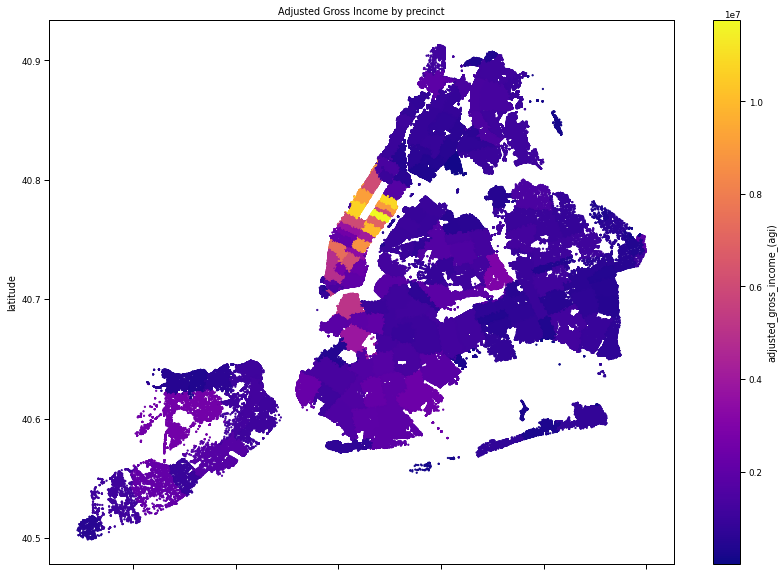

In [250]:
complaints.plot(kind="scatter", x="longitude", y="latitude", c="adjusted_gross_income_(agi)",
                cmap="plasma", figsize=(14,10), s=2);
plt.title('Adjusted Gross Income by precinct');

---

## Modeling
Predicting the number of arrests using the following features:
 - complaint breakdown by crime
 - population demographics
 - average income

For this purpose, the following models are created below:
 - multiple linear regression
 - multiple linear regression with L2/Ridge regularization
 - multiple linear regression with elastic net regularization
 - multiple linear regression using primary componenents and elastic net regularization
 - decision tree regression
 - bagging regression
 
Linear regressions were the primary choice of modeling techniques here because of their high interpretability

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, ElasticNetCV, ElasticNet


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
#from tensorflow.keras import utils

In [43]:
X = cross.drop(columns = ['arrests', 'precinct', 'precinct_2020', 'apc'])
y = cross['arrests']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [45]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_sc = sc.fit_transform(X) # for use with cross-validated models

In [46]:
X_train.shape, X_test.shape

((57, 145), (19, 145))

---

#### OLS Linear Regression

In [262]:
lm = LinearRegression(n_jobs=4)
lm.fit(X_train_sc, y_train)

LinearRegression(n_jobs=4)

In [263]:
lm.score(X_train_sc, y_train), lm.score(X_test_sc, y_test)

(1.0, 0.7029845343656429)

---

#### Ridge Linear Regression
The intent of this model is to use cross validation against L2 regularization to see if the best fit will translate well on unseen 'test' data.

In [264]:
r_alphas = np.logspace(0, 10, 1000)
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv.fit(X_train_sc, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.02331658e+00, 1.04717682e+00, 1.07159340e+00,
       1.09657929e+00, 1.12214777e+00, 1.14831241e+00, 1.17508713e+00,
       1.20248614e+00, 1.23052400e+00, 1.25921561e+00, 1.28857621e+00,
       1.31862140e+00, 1.34936714e+00, 1.38082977e+00, 1.41302599e+00,
       1.44597292e+00, 1.47968806e+00, 1.51418933e+00, 1.54949504e+00,
       1.58562396e+00, 1.62259529e+0...
       5.88531578e+09, 6.02254120e+09, 6.16296626e+09, 6.30666554e+09,
       6.45371540e+09, 6.60419396e+09, 6.75818117e+09, 6.91575883e+09,
       7.07701066e+09, 7.24202233e+09, 7.41088152e+09, 7.58367791e+09,
       7.76050334e+09, 7.94145172e+09, 8.12661920e+09, 8.31610415e+09,
       8.51000725e+09, 8.70843150e+09, 8.91148232e+09, 9.11926760e+09,
       9.33189772e+09, 9.54948564e+09, 9.77214697e+09, 1.00000000e+10]),
        cv=5, scoring='r2')

In [265]:
ridge_cv.alpha_

1.0

In [266]:
ridge_cv.score(X_test_sc, y_test)

0.7032530852216353

---
#### Elastic Net Linear Regression
The intent of this model is to use cross validation against both L1 and L2 regularization to get a sense of what works best for this data set, and then attempt to use the best fit on witheld 'test' data.

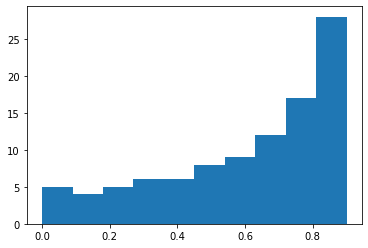

In [47]:
# Docs say we should check more values near 1 than 0
enet_ratio = np.abs(1 - np.logspace(-1, 0, 100))
plt.hist(enet_ratio);

In [48]:
enet_alphas = np.logspace(-1, 1, 100)
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, n_jobs=4,
                          random_state=1, max_iter=5000)
enet_model.fit(X_train_sc, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7016231.226466468, tolerance: 2395.786991111111
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6933564.107217494, tolerance: 2395.786991111111
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10663407.454089055, tolerance: 2984.393297777778
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

ElasticNetCV(alphas=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.38535286,
        0....
       0.4905862 , 0.47859917, 0.46633008, 0.45377228, 0.44091898,
       0.42776323, 0.41429792, 0.40051575, 0.38640927, 0.37197086,
       0.35719269, 0.34206678, 0.32658493, 0.31073879, 0.29451977,
       0.2779191 , 0.2609278 , 0.24353667, 0.22573632, 0.2075171 ,
       0.18886917, 0.16978243, 0.15024656, 0.130251  , 0.10978491,
       0.08883724, 0.06739665, 0.04545154, 0.02299004, 0.        ]),
             max_iter=5000, n_jobs=4, random_state=1)

In [49]:
enet_model.alpha_

4.5348785081285845

In [50]:
enet_model.l1_ratio_

0.9

In [51]:
enet_model.score(X_train_sc, y_train), enet_model.score(X_test_sc, y_test)

(0.8299376767574194, 0.48455576412131296)

---
Given that there are very few data samples, adding more data by using just cross-validation and not withholding data to fit with should give the best results.

In [52]:
enet2 = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, n_jobs=4,
                          random_state=1, max_iter=5000)
enet2.fit(X_sc, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9613031.108891472, tolerance: 3529.0095600000004
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9469367.864182103, tolerance: 3529.0095600000004
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9326191.361872729, tolerance: 3529.0095600000004
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

ElasticNetCV(alphas=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.38535286,
        0....
       0.4905862 , 0.47859917, 0.46633008, 0.45377228, 0.44091898,
       0.42776323, 0.41429792, 0.40051575, 0.38640927, 0.37197086,
       0.35719269, 0.34206678, 0.32658493, 0.31073879, 0.29451977,
       0.2779191 , 0.2609278 , 0.24353667, 0.22573632, 0.2075171 ,
       0.18886917, 0.16978243, 0.15024656, 0.130251  , 0.10978491,
       0.08883724, 0.06739665, 0.04545154, 0.02299004, 0.        ]),
             max_iter=5000, n_jobs=4, random_state=1)

In [53]:
enet2.alpha_

4.977023564332112

In [54]:
enet2.l1_ratio_

0.9

In [55]:
enet2.score(X_sc, y)

0.8113663116969275

---

Manually changing the level of regularization on this model to see if anything better than our cross-validated results is achievable.

In [56]:
enet3 = ElasticNet(alpha=1, l1_ratio=0.9, random_state=1, max_iter=5000)
enet3.fit(X_train_sc, y_train)

ElasticNet(alpha=1, l1_ratio=0.9, max_iter=5000, random_state=1)

In [58]:
enet3.score(X_train_sc, y_train), enet3.score(X_test_sc, y_test)

(0.96136170421834, 0.1123937304455569)

---

Visualizing the results of our cross-validated model.  Plot the predicted number of arrests against the actual number.

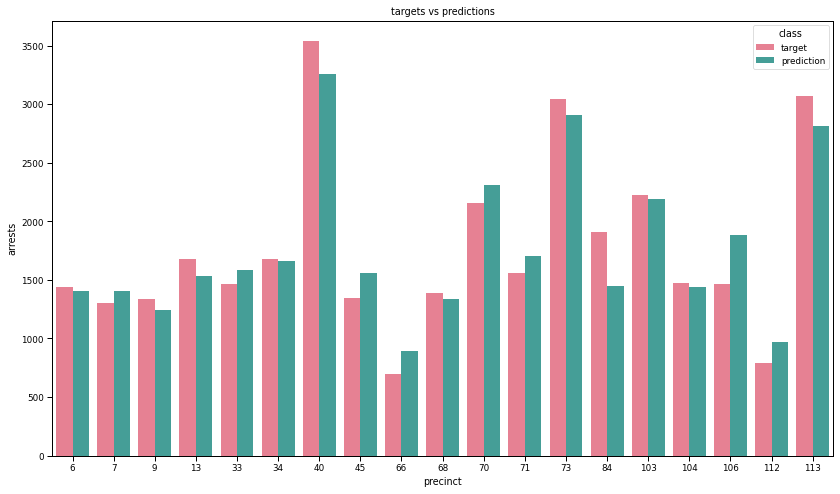

In [63]:
sns.set_context('talk')
preds = enet2.predict(X_test_sc)

results = pd.DataFrame(y_test)
results['class'] = 'target'
results.reset_index(inplace=True)
results.rename(columns={'index':'sample'}, inplace=True)
results['precinct'] = cross.iloc[results['sample']]['precinct'].values
#results.drop(columns='level_0', inplace=True)

preds_df = pd.DataFrame(preds)
preds_df['sample']=results['sample']
preds_df.rename(columns={0:'arrests'}, inplace=True)
preds_df['class'] = 'prediction'
preds_df['precinct'] = cross.iloc[results['sample']]['precinct'].values

results = pd.concat([results, preds_df])

plt.figure(figsize=(14,8))
sns.set_context('paper')
rplot = sns.barplot(data=results, y='arrests', x='precinct',
                    hue='class', palette=sns.husl_palette(2)).set(title='targets vs predictions')
plt.savefig('arrest_targs.jpg')

Examine the coefficients to determine factors of possible influence

In [121]:
ecoefs = pd.DataFrame(zip(X_train.columns, enet2.coef_), columns=['feature','coef'])

In [122]:
ecoefs.sort_values('coef', ascending=False).head(20)

,feature,coef
0,complaints,321.335878
135,P0020064,62.586765
105,P0020034,56.895686
69,P0010069,50.981881
52,P0010052,46.367291
60,P0010060,36.614408
62,P0010062,35.973662
125,P0020054,28.011074
16,P0010016,26.841956
116,P0020045,26.646327


In [124]:
ecoefs.sort_values('coef', ascending=False).tail(10)

,feature,coef
129,P0020058,-29.025767
111,P0020040,-29.509781
133,P0020062,-32.452528
108,P0020037,-32.752395
85,P0020014,-33.685474
35,P0010035,-36.522134
3,P0010003,-39.678081
101,P0020030,-41.531340
76,P0020005,-43.575369
28,P0010028,-47.569536


---
#### PCA Elastic Net Linear Regression

In [276]:
pca = PCA()
pca.fit(X_train_sc)
Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [277]:
enet_alphas = np.logspace(-2, 1, 100)
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, n_jobs=4,
                          random_state=1, max_iter=5000)
enet_model.fit(Z_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3775159.358337139, tolerance: 2395.786991111111
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3370016.286800847, tolerance: 2984.393297777778
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3684350.777146413, tolerance: 3134.9514717391307
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

ElasticNetCV(alphas=array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722368,  0.06135907,  0.06579332,  0.07054802,  0.07564633,...
       0.4905862 , 0.47859917, 0.46633008, 0.45377228, 0.44091898,
       0.42776323, 0.41429792, 0.40051575, 0.38640927, 0.37197086,
       0.35719269, 0.34206678, 0.32658493, 0.31073879, 0.29451977,
       0.2779191 , 0.2609278 , 0.24353667, 0.22573632, 0.2075171 ,
       0.18886917, 0.16978243, 0.15024656, 0.130251  , 0.10978491,
       0.08883724, 0.06739665, 0.04545154, 0.02299004, 0.        ]),
             max_iter=5000, n_jobs=4, random_state=1)

In [278]:
enet_model.alpha_

0.01

In [279]:
enet_model.l1_ratio_

0.8126182577139616

In [280]:
enet_model.score(Z_train, y_train), enet_model.score(Z_test, y_test)

(0.9999999453754373, 0.7037326509281983)

---

#### Decision Tree

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_sc, y_train)

In [ ]:
dt.score(X_train_sc, y_train), dt.score(X_test_sc, y_test)

---

#### Bagging

In [ ]:
bag = BaggingRegressor()
bag.fit(X_train_sc, y_train)

In [ ]:
bag.score(X_train_sc, y_train), bag.score(X_test_sc, y_test)

Trying with some tuning

In [ ]:
bag_params = {'n_estimators': [20, 30, 40]}

In [ ]:
bag2 = BaggingRegressor(n_jobs=4)
bag_search = GridSearchCV(bag2,
                          bag_params,
                          cv=5,
                          n_jobs=2,
                          verbose=0)

In [ ]:
bag_search.fit(X_sc, y)

In [ ]:
bag_search.best_params_

In [ ]:
bag_search.best_score_

---

### Modeling for arrests per complaint

Alternate model; Better for problem questions: "Do complaints drive arrests or are there more factors, and if so, what?"

In [339]:
X = cross.drop(columns = ['arrests', 'precinct', 'precinct_2020', 'apc'])
y = cross['apc']

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [341]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_sc = sc.fit_transform(X) # for use with cross-validated models

In [342]:
pca = PCA()
pca.fit(X_train_sc)
Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [348]:
enet_alphas = np.logspace(-2, 1, 100)
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, n_jobs=4,
                          random_state=42, max_iter=5000)
enet_model.fit(Z_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012527157756585, tolerance: 6.23743939278174e-06
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01217794660523392, tolerance: 5.472305595490078e-06
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012618404761541921, tolerance: 5.928374871073918e-06
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

ElasticNetCV(alphas=array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722368,  0.06135907,  0.06579332,  0.07054802,  0.07564633,...
       0.4905862 , 0.47859917, 0.46633008, 0.45377228, 0.44091898,
       0.42776323, 0.41429792, 0.40051575, 0.38640927, 0.37197086,
       0.35719269, 0.34206678, 0.32658493, 0.31073879, 0.29451977,
       0.2779191 , 0.2609278 , 0.24353667, 0.22573632, 0.2075171 ,
       0.18886917, 0.16978243, 0.15024656, 0.130251  , 0.10978491,
       0.08883724, 0.06739665, 0.04545154, 0.02299004, 0.        ]),
             max_iter=5000, n_jobs=4, random_state=42)

In [352]:
enet_model.alpha_

7.054802310718645

In [353]:
enet_model.l1_ratio_

0.0

In [355]:
enet_model.score(Z_train, y_train), enet_model.score(Z_test, y_test)

(0.8048539817003901, -0.1382742160596746)

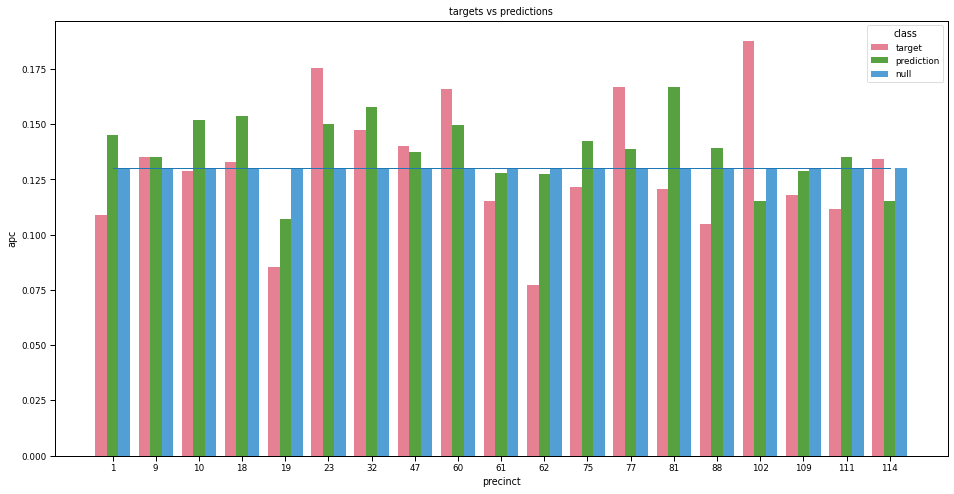

In [419]:
preds = enet_model.predict(Z_test)

results = pd.DataFrame(y_test)
results['class'] = 'target'
results.reset_index(inplace=True)
results.rename(columns={'index':'sample'}, inplace=True)
results['precinct'] = cross.iloc[results['sample']]['precinct'].values
#results.drop(columns='level_0', inplace=True)

preds_df = pd.DataFrame(preds)
preds_df['sample']=results['sample']
preds_df.rename(columns={0:'apc'}, inplace=True)
preds_df['class'] = 'prediction'
preds_df['precinct'] = cross.iloc[results['sample']]['precinct'].values

null = pd.DataFrame(index = preds_df.index, data = preds_df.precinct)
null['class'] = 'null'
null['apc'] = y_test.mean()

results = pd.concat([results, preds_df, null])

plt.figure(figsize=(16,8))
sns.set_context('paper')
rplot = sns.barplot(data=results, y='apc', x='precinct', hue='class',
                    palette=sns.husl_palette(3)).set(title='targets vs predictions')
plt.plot([0.13]*19, linewidth=1);

In [114]:
null = pd.DataFrame(index = preds_df.index, data = preds_df.precinct)

null['class'] = 'null'
null['apc'] = y_test.mean()

In [115]:
len(preds)

19

In [116]:
results.head()

,sample,arrests,class,precinct
0,68,792.0,target,112
1,26,1345.0,target,45
2,21,3539.0,target,40
3,3,1303.0,target,7
4,44,3044.0,target,73


---
### Neural Network

In [371]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [370]:
X_train_sc.shape

(57, 515)

In [372]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(515,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation=None))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [392]:
model_made = model.fit(X_train_sc, y_train, epochs=100, validation_data=(X_test_sc, y_test),
                    verbose=0)

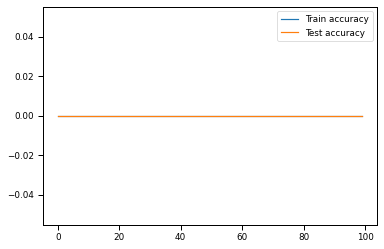

In [393]:
plt.plot(model_made.history['accuracy'], label='Train accuracy')
plt.plot(model_made.history['val_accuracy'], label='Test accuracy')
plt.legend();

In [385]:
results.history

{'loss': [3.221205040985359e-13,
  0.00027371806208975613,
  0.4191969037055969,
  0.01696724258363247,
  0.11666424572467804,
  0.12698602676391602,
  0.03416212648153305,
  0.010563170537352562,
  0.031366582959890366,
  0.026821447536349297],
 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [0.015859773382544518,
  0.1837698519229889,
  0.013537771068513393,
  0.06332220882177353,
  0.06934709846973419,
  0.030738767236471176,
  0.018297290429472923,
  0.0313444547355175,
  0.03059782087802887,
  0.019296294078230858],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

---
## Conclusions
Modeling arrests per complaint was not successful, but modeling arrests themselves was.  By using a linear regression, we were left with coefficients that could be used to help determine what some factors could be that keep arrests from scaling directly with complaints.

The purpose of this model is the prediction of arrest count by using complaint data broken down by crime type, full census population demographics, and average income by precinct.  A linear regression was chosen for the highest interpretability and elastic net regularization was used to decrease bias.

Using both a train/test split and cross-validated scores:
Training set = 515 columns, 57 rows (19 rows used to test)
Train R2 score: .9999	Test R2 score: .7206 
Cross-validated without train/test split score: .9999

This model would benefit from a data set that spans multiple years to increase the number of samples and includes further details within each record.
